In [1]:
import os
os.chdir('../')

In [2]:
%matplotlib inline
#%matplotlib notebook

%load_ext autoreload
%autoreload 2

In [3]:
from copy import deepcopy
from decimal import Decimal
from typing import List, Tuple
from warnings import warn

from cycler import cycler
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import PCA
import scipy.stats as stats
import torch
from torch import nn
import torch.nn.functional as F
import seml
from ogb.nodeproppred import PygNodePropPredDataset

import tqdm
tqdm.tqdm.pandas()

In [4]:
from notebooks import mpl_latex

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [5]:
mpl_latex.enable_production_mode()

In [6]:
from rgnn_at_scale.data import prep_graph, split
from rgnn_at_scale.attacks import create_attack, SPARSE_ATTACKS
from rgnn_at_scale.helper.io import Storage
from rgnn_at_scale.models import DenseGCN, GCN
from rgnn_at_scale.train import train
from rgnn_at_scale.helper.utils import accuracy

# Effectiveness for different block sizes

In [7]:
dataset = 'ogbn-arxiv'
binary_attr = False
attack = 'PRBCD'
seed = 0
device = 0
surrogate_params = {
    'n_filters': [256, 256],
    'dropout': 0.5,
    'with_batchnorm': True,
    'train_params': {
        'lr': 1e-2,
        'weight_decay': 0,
        'patience': 300,
        'max_epochs': 3000
    }
}
attack_params = {
    'keep_heuristic': 'WeightOnly',
    'loss_type': 'tanhMargin'
}
search_space_sizes = [350_000, 600_000, 1_000_000, 10_000_000, 20_000_000]
epsilon = 0.1
display_steps = 10

torch.manual_seed(seed)
np.random.seed(seed)

In [8]:
data = prep_graph(dataset, device='cpu', binary_attr=binary_attr, make_undirected=True, return_original_split=dataset.startswith('ogbn'))
if len(data) == 3:
    attr, adj, labels = data
    idx_train, idx_val, idx_test = data.split(labels.cpu().numpy())
else:
    attr, adj, labels, split = data
    idx_train, idx_val, idx_test = split['train'], split['valid'], split['test']
n_features = attr.shape[1]
n_classes = int(labels.max() + 1)

In [9]:
gcn = GCN(n_classes=n_classes, n_features=n_features, **surrogate_params).to(device)
train(model=gcn, attr=attr.to(device), adj=adj.to(device), labels=labels.to(device),
      idx_train=idx_train, idx_val=idx_val, display_step=display_steps, **surrogate_params['train_params'])

Training...:   0%|          | 0/3000 [00:00<?, ?it/s]

([3.6803221702575684,
  3.3011386394500732,
  3.1253364086151123,
  3.091355800628662,
  3.092853546142578,
  3.118133068084717,
  3.1171462535858154,
  2.989225149154663,
  2.860402822494507,
  2.7737905979156494,
  2.7171685695648193,
  2.644099473953247,
  2.5090339183807373,
  2.3906261920928955,
  2.2983908653259277,
  2.2454802989959717,
  2.1638426780700684,
  2.072758197784424,
  2.005610227584839,
  1.9740118980407715,
  1.914901614189148,
  1.8531126976013184,
  1.8153612613677979,
  1.7695488929748535,
  1.7240490913391113,
  1.6937404870986938,
  1.6799681186676025,
  1.6358236074447632,
  1.6089063882827759,
  1.5808699131011963,
  1.548453688621521,
  1.5245743989944458,
  1.503406047821045,
  1.48654043674469,
  1.472662329673767,
  1.4494519233703613,
  1.426102638244629,
  1.4095126390457153,
  1.390886664390564,
  1.3782545328140259,
  1.3626352548599243,
  1.3563464879989624,
  1.3410420417785645,
  1.3343013525009155,
  1.318767786026001,
  1.3024731874465942,
  1.2

In [10]:
with torch.no_grad():
    pred_logits_surr = gcn(attr.to(device), adj.to(device))
accuracy(pred_logits_surr, labels.to(device), idx_test)

0.6984136700630188

# Compensate block size with more epochs

In [11]:
search_space_sizes = [1_000_000, 2_000_000, 10_000_000]
line_styles = ['-', '--', ':']
epochs = [1000, 500, 100]

results = []
for epoch, search_space_size in zip(epochs, search_space_sizes):
    temp_attack_params = dict(attack_params)
    temp_attack_params['search_space_size'] = search_space_size
    temp_attack_params['epochs'] = epoch
    temp_attack_params['fine_tune_epochs'] = 0
    temp_attack_params['with_early_stropping'] = False
    adversary = create_attack(attack, adj=adj, attr=attr, binary_attr=False, labels=labels, make_undirected=True,
                              model=gcn, idx_attack=idx_test, device=device, data_device=device, **temp_attack_params)

    m = adj.nnz() / 2
    torch.manual_seed(seed)
    np.random.seed(seed)

    n_perturbations = int(round(epsilon * m))
    adversary.attack(n_perturbations)
    
    results.append(adversary.attack_statistics)

  0%|          | 0/1000 [00:00<?, ?it/s]


Before the attack - Loss: -0.3935643136501312 Accuracy: 71.230 %



  0%|          | 1/1000 [00:00<06:45,  2.47it/s]


Epoch: 0 Loss: -0.39356428384780884 Accuracy: 69.699 %



  2%|▏         | 21/1000 [00:08<06:20,  2.58it/s]


Epoch: 20 Loss: -0.038684114813804626 Accuracy: 49.240 %



  4%|▍         | 41/1000 [00:15<06:11,  2.58it/s]


Epoch: 40 Loss: 0.08152090013027191 Accuracy: 43.553 %



  6%|▌         | 61/1000 [00:24<06:45,  2.32it/s]


Epoch: 60 Loss: 0.14515241980552673 Accuracy: 40.666 %



  8%|▊         | 81/1000 [00:31<05:56,  2.57it/s]


Epoch: 80 Loss: 0.18847140669822693 Accuracy: 38.613 %



 10%|█         | 101/1000 [00:39<05:49,  2.57it/s]


Epoch: 100 Loss: 0.2194347232580185 Accuracy: 37.308 %



 12%|█▏        | 121/1000 [00:47<05:40,  2.58it/s]


Epoch: 120 Loss: 0.24319157004356384 Accuracy: 36.224 %



 14%|█▍        | 141/1000 [00:55<05:33,  2.57it/s]


Epoch: 140 Loss: 0.2623242139816284 Accuracy: 35.399 %



 16%|█▌        | 161/1000 [01:03<05:25,  2.57it/s]


Epoch: 160 Loss: 0.2789028286933899 Accuracy: 34.638 %



 18%|█▊        | 181/1000 [01:10<05:17,  2.58it/s]


Epoch: 180 Loss: 0.2927076816558838 Accuracy: 34.023 %



 20%|██        | 201/1000 [01:18<05:11,  2.57it/s]


Epoch: 200 Loss: 0.30450108647346497 Accuracy: 33.525 %



 22%|██▏       | 221/1000 [01:26<05:02,  2.58it/s]


Epoch: 220 Loss: 0.31461071968078613 Accuracy: 33.068 %



 24%|██▍       | 241/1000 [01:34<04:56,  2.56it/s]


Epoch: 240 Loss: 0.3238111436367035 Accuracy: 32.665 %



 26%|██▌       | 261/1000 [01:42<05:15,  2.34it/s]


Epoch: 260 Loss: 0.3319321274757385 Accuracy: 32.292 %



 28%|██▊       | 281/1000 [01:50<04:55,  2.43it/s]


Epoch: 280 Loss: 0.33888325095176697 Accuracy: 32.017 %



 30%|███       | 301/1000 [01:58<04:31,  2.58it/s]


Epoch: 300 Loss: 0.3455130159854889 Accuracy: 31.700 %



 32%|███▏      | 321/1000 [02:06<04:24,  2.57it/s]


Epoch: 320 Loss: 0.35158219933509827 Accuracy: 31.455 %



 34%|███▍      | 341/1000 [02:14<04:20,  2.53it/s]


Epoch: 340 Loss: 0.35724228620529175 Accuracy: 31.214 %



 36%|███▌      | 361/1000 [02:22<04:08,  2.58it/s]


Epoch: 360 Loss: 0.3624911308288574 Accuracy: 30.965 %



 38%|███▊      | 381/1000 [02:30<04:00,  2.58it/s]


Epoch: 380 Loss: 0.36742886900901794 Accuracy: 30.764 %



 40%|████      | 401/1000 [02:38<03:52,  2.58it/s]


Epoch: 400 Loss: 0.37201806902885437 Accuracy: 30.550 %



 42%|████▏     | 421/1000 [02:45<03:45,  2.57it/s]


Epoch: 420 Loss: 0.3757968544960022 Accuracy: 30.385 %



 44%|████▍     | 441/1000 [02:53<03:36,  2.58it/s]


Epoch: 440 Loss: 0.3796810209751129 Accuracy: 30.222 %



 46%|████▌     | 461/1000 [03:01<03:29,  2.57it/s]


Epoch: 460 Loss: 0.38337329030036926 Accuracy: 30.072 %



 48%|████▊     | 481/1000 [03:09<03:21,  2.58it/s]


Epoch: 480 Loss: 0.3869802951812744 Accuracy: 29.904 %



 50%|█████     | 501/1000 [03:16<03:17,  2.52it/s]


Epoch: 500 Loss: 0.3905790448188782 Accuracy: 29.731 %



 52%|█████▏    | 521/1000 [03:24<03:06,  2.57it/s]


Epoch: 520 Loss: 0.3939421474933624 Accuracy: 29.578 %



 54%|█████▍    | 541/1000 [03:32<02:58,  2.57it/s]


Epoch: 540 Loss: 0.3968047797679901 Accuracy: 29.451 %



 56%|█████▌    | 561/1000 [03:40<02:50,  2.57it/s]


Epoch: 560 Loss: 0.39994603395462036 Accuracy: 29.299 %



 58%|█████▊    | 581/1000 [03:48<02:42,  2.58it/s]


Epoch: 580 Loss: 0.4029117226600647 Accuracy: 29.159 %



 60%|██████    | 601/1000 [03:56<02:35,  2.57it/s]


Epoch: 600 Loss: 0.4055609107017517 Accuracy: 29.043 %



 62%|██████▏   | 621/1000 [04:04<02:27,  2.57it/s]


Epoch: 620 Loss: 0.4084094166755676 Accuracy: 28.918 %



 64%|██████▍   | 641/1000 [04:12<02:19,  2.58it/s]


Epoch: 640 Loss: 0.4109659194946289 Accuracy: 28.801 %



 66%|██████▌   | 661/1000 [04:19<02:11,  2.57it/s]


Epoch: 660 Loss: 0.413442462682724 Accuracy: 28.698 %



 68%|██████▊   | 681/1000 [04:27<02:04,  2.56it/s]


Epoch: 680 Loss: 0.41583961248397827 Accuracy: 28.593 %



 70%|███████   | 701/1000 [04:35<01:56,  2.58it/s]


Epoch: 700 Loss: 0.4182092249393463 Accuracy: 28.461 %



 72%|███████▏  | 721/1000 [04:43<01:48,  2.58it/s]


Epoch: 720 Loss: 0.4204808175563812 Accuracy: 28.362 %



 74%|███████▍  | 741/1000 [04:50<01:40,  2.58it/s]


Epoch: 740 Loss: 0.42249393463134766 Accuracy: 28.286 %



 76%|███████▌  | 761/1000 [04:58<01:35,  2.50it/s]


Epoch: 760 Loss: 0.4245906174182892 Accuracy: 28.175 %



 78%|███████▊  | 781/1000 [05:07<01:26,  2.54it/s]


Epoch: 780 Loss: 0.4272504448890686 Accuracy: 28.031 %



 80%|████████  | 801/1000 [05:15<01:20,  2.48it/s]


Epoch: 800 Loss: 0.430225670337677 Accuracy: 27.891 %



 82%|████████▏ | 821/1000 [05:23<01:10,  2.53it/s]


Epoch: 820 Loss: 0.4330222010612488 Accuracy: 27.737 %



 84%|████████▍ | 841/1000 [05:31<01:02,  2.54it/s]


Epoch: 840 Loss: 0.43568962812423706 Accuracy: 27.603 %



 86%|████████▌ | 861/1000 [05:39<00:54,  2.53it/s]


Epoch: 860 Loss: 0.4385395348072052 Accuracy: 27.447 %



 88%|████████▊ | 881/1000 [05:47<00:46,  2.53it/s]


Epoch: 880 Loss: 0.4413825571537018 Accuracy: 27.299 %



 90%|█████████ | 901/1000 [05:55<00:39,  2.54it/s]


Epoch: 900 Loss: 0.4441414177417755 Accuracy: 27.140 %



 92%|█████████▏| 921/1000 [06:03<00:31,  2.54it/s]


Epoch: 920 Loss: 0.4469221830368042 Accuracy: 26.996 %



 94%|█████████▍| 941/1000 [06:11<00:23,  2.54it/s]


Epoch: 940 Loss: 0.44939178228378296 Accuracy: 26.856 %



 96%|█████████▌| 961/1000 [06:18<00:15,  2.54it/s]


Epoch: 960 Loss: 0.45195305347442627 Accuracy: 26.727 %



 98%|█████████▊| 981/1000 [06:26<00:07,  2.54it/s]


Epoch: 980 Loss: 0.45438623428344727 Accuracy: 26.603 %



  0%|          | 0/500 [00:00<?, ?it/s]


Before the attack - Loss: -0.3935643136501312 Accuracy: 71.230 %



  0%|          | 1/500 [00:00<04:42,  1.76it/s]


Epoch: 0 Loss: -0.39356428384780884 Accuracy: 68.747 %



  4%|▍         | 21/500 [00:11<04:31,  1.77it/s]


Epoch: 20 Loss: 0.04807296395301819 Accuracy: 44.545 %



  8%|▊         | 41/500 [00:23<04:20,  1.77it/s]


Epoch: 40 Loss: 0.1751106083393097 Accuracy: 38.829 %



 12%|█▏        | 61/500 [00:34<04:25,  1.65it/s]


Epoch: 60 Loss: 0.2392098754644394 Accuracy: 36.086 %



 16%|█▌        | 81/500 [00:46<03:57,  1.76it/s]


Epoch: 80 Loss: 0.2796795964241028 Accuracy: 34.298 %



 20%|██        | 101/500 [00:57<03:49,  1.74it/s]


Epoch: 100 Loss: 0.30872175097465515 Accuracy: 33.031 %



 24%|██▍       | 121/500 [01:09<03:35,  1.76it/s]


Epoch: 120 Loss: 0.3310084342956543 Accuracy: 32.060 %



 28%|██▊       | 141/500 [01:20<03:23,  1.77it/s]


Epoch: 140 Loss: 0.34850889444351196 Accuracy: 31.315 %



 32%|███▏      | 161/500 [01:31<03:11,  1.77it/s]


Epoch: 160 Loss: 0.3625262975692749 Accuracy: 30.722 %



 36%|███▌      | 181/500 [01:43<03:00,  1.76it/s]


Epoch: 180 Loss: 0.3751040995121002 Accuracy: 30.161 %



 40%|████      | 201/500 [01:54<02:59,  1.66it/s]


Epoch: 200 Loss: 0.38588884472846985 Accuracy: 29.706 %



 44%|████▍     | 221/500 [02:06<02:38,  1.76it/s]


Epoch: 220 Loss: 0.3953286111354828 Accuracy: 29.290 %



 48%|████▊     | 241/500 [02:17<02:32,  1.70it/s]


Epoch: 240 Loss: 0.40293359756469727 Accuracy: 28.951 %



 52%|█████▏    | 261/500 [02:29<02:20,  1.70it/s]


Epoch: 260 Loss: 0.4103218913078308 Accuracy: 28.630 %



 56%|█████▌    | 281/500 [02:40<02:04,  1.76it/s]


Epoch: 280 Loss: 0.4176023602485657 Accuracy: 28.295 %



 60%|██████    | 301/500 [02:52<01:52,  1.77it/s]


Epoch: 300 Loss: 0.4238074719905853 Accuracy: 28.015 %



 64%|██████▍   | 321/500 [03:03<01:41,  1.77it/s]


Epoch: 320 Loss: 0.4293600916862488 Accuracy: 27.780 %



 68%|██████▊   | 341/500 [03:14<01:31,  1.75it/s]


Epoch: 340 Loss: 0.43453264236450195 Accuracy: 27.544 %



 72%|███████▏  | 361/500 [03:26<01:20,  1.74it/s]


Epoch: 360 Loss: 0.439983069896698 Accuracy: 27.249 %



 76%|███████▌  | 381/500 [03:37<01:09,  1.72it/s]


Epoch: 380 Loss: 0.4460105001926422 Accuracy: 26.963 %



 80%|████████  | 401/500 [03:49<00:57,  1.73it/s]


Epoch: 400 Loss: 0.45251303911209106 Accuracy: 26.601 %



 84%|████████▍ | 421/500 [04:01<00:45,  1.73it/s]


Epoch: 420 Loss: 0.45868054032325745 Accuracy: 26.293 %



 88%|████████▊ | 441/500 [04:12<00:34,  1.73it/s]


Epoch: 440 Loss: 0.464338093996048 Accuracy: 25.988 %



 92%|█████████▏| 461/500 [04:24<00:22,  1.71it/s]


Epoch: 460 Loss: 0.46971890330314636 Accuracy: 25.710 %



 96%|█████████▌| 481/500 [04:36<00:10,  1.74it/s]


Epoch: 480 Loss: 0.47505202889442444 Accuracy: 25.449 %



  0%|          | 0/100 [00:00<?, ?it/s]


Before the attack - Loss: -0.3935643136501312 Accuracy: 71.230 %



  1%|          | 1/100 [00:02<03:24,  2.06s/it]


Epoch: 0 Loss: -0.39356422424316406 Accuracy: 64.364 %



 21%|██        | 21/100 [00:42<02:43,  2.06s/it]


Epoch: 20 Loss: 0.2634558081626892 Accuracy: 34.103 %



 41%|████      | 41/100 [01:23<02:02,  2.07s/it]


Epoch: 40 Loss: 0.3759859800338745 Accuracy: 29.502 %



 61%|██████    | 61/100 [02:05<01:20,  2.07s/it]


Epoch: 60 Loss: 0.4271257817745209 Accuracy: 27.373 %



 81%|████████  | 81/100 [02:47<00:39,  2.10s/it]


Epoch: 80 Loss: 0.4581150412559509 Accuracy: 25.918 %



100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


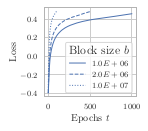

In [12]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)
for result, search_space_size, line_style in zip(results, search_space_sizes, line_styles):
    ax.plot(result['loss'], line_style, label=rf'${search_space_size:.1E}$')
    plt.gca().set_prop_cycle(None)
    
plt.xlabel('Epochs $t$')
plt.ylabel('Loss')    
mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0_1_block_size_cmp_epochs_loss_no_legend', fig, close_fig=False)
plt.legend(title=f'Block size $b$')
mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0_1_block_size_cmp_epochs_loss', fig, close_fig=False)
mpl_latex.dedicated_legend_plot(
    f'latex/assets/global_prbcd_arxiv_0_1_block_size_cmp_epochs_loss_legend',
    mod_label=lambda l: l,
    ncol=3
)    
    
plt.gcf()

/nfs/staff-ssd/geisler/anaconda3/envs/rgnn_at_scale_refactoring/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


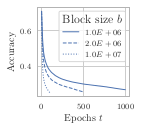

In [13]:
fig, ax = mpl_latex.newfig(width=0.30, ratio_yx=1)
for result, search_space_size, line_style in zip(results, search_space_sizes, line_styles):
    plt.plot(result['accuracy'], line_style, label=rf'${search_space_size:.1E}$')
    plt.gca().set_prop_cycle(None)
    
plt.xlabel('Epochs $t$')
plt.ylabel('Accuracy')
mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0.1_block_size_cmp_epochs_accuracy_no_legend', fig, close_fig=False)
plt.legend(title=r'Block size $b$')
mpl_latex.savefig(f'latex/assets/global_prbcd_arxiv_0.1_block_size_cmp_epochs_accuracy', fig, close_fig=False)
mpl_latex.dedicated_legend_plot(
    f'latex/assets/global_prbcd_arxiv_0.1_block_size_cmp_epochs_accuracy_legend',
    mod_label=lambda l: l,
    ncol=3
)
    
plt.gcf()